In [1]:
import os, glob
import cv2, numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import skimage
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from scipy.ndimage.measurements import label
import sklearn

In [2]:
IMGS_INFO = '/Users/sarthak/Downloads/torrents/data_1_10.11.13.14f.15.17.18.19/'
imgs = glob.glob(IMGS_INFO + '/**/labelled/*intensity*.png')
print ('Number of images:', len(imgs))

('Number of images:', 16440)


In [3]:
#Create car and noncar data
bbox_data = []
for idx, img_file in enumerate(imgs):
    bboxfile = os.path.join(img_file[:-4] + '.txt').replace('labelled', '')
    data_line = open(bboxfile, 'r').readlines()[0].split(' ')
    if data_line[0][0] == '[' and data_line[1][0] == '[':
        bbox_data.append([float(data_line[0][1:-2]), float(data_line[1][1:-2]), float(data_line[2])])

In [4]:
car_images, non_car_images = [], []
for img_file, bbox in zip(imgs, bbox_data):
    single_channel_im1 = cv2.imread(img_file)[:, :, 0]
    single_channel_im2 = cv2.imread(img_file.replace('intensity', 'distance'))[:, :, 0]
    single_channel_im = np.vstack((single_channel_im1, single_channel_im2))
    car_images.append(single_channel_im[:, bbox[0] - 50 : bbox[0] + 50])
    if car_images[-1].shape[0] == 0 or car_images[-1].shape[1] == 0:
        if (bbox[0] - 50) < 0:
            car_images[-1] = single_channel_im[:, 0:100]
        else:
            car_images[-1] = single_channel_im[:, -100:-1]
    for x1 in range(0, int(bbox[0]) - 50, 100)[:-1]:
        non_car_images.append(single_channel_im[:, x1 : (x1 + 100)])
    for x2 in range(int(bbox[0]) + 50, single_channel_im.shape[1] - 1, 100)[:-1]:
        non_car_images.append(single_channel_im[:, x2 : (x2 + 100)])
    if non_car_images[-1].shape[1] == 0:
        print img_file

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.


In [5]:
print('Number of car images:', len(car_images), ' with shape:', car_images[0].shape)
print('Number of non car images:', len(non_car_images), ' with shape:', non_car_images[0].shape)
min_img_count = min([len(car_images), len(non_car_images), 15000])
print('Number of min image count:', len(non_car_images), ' with shape:', non_car_images[0].shape)

('Number of car images:', 15755, ' with shape:', (138, 100))
('Number of non car images:', 64909, ' with shape:', (138, 100))
('Number of min image count:', 64909, ' with shape:', (138, 100))


In [28]:
# Define a function to extract features from a list of images
def extract_features(imgs):
    features = []
    # Iterate through the list of images
    for feature_image in imgs:
        features.append(np.reshape(feature_image, (feature_image.shape[0], feature_image.shape[1], -1)))
    # Return list of feature vectors
    return features

In [30]:
def generate_features(vehicle_imgs, non_vehicle_imgs):
    car_features = extract_features(vehicle_imgs)
    not_car_features = extract_features(non_vehicle_imgs)
    print ('Size of car features:', np.array(car_features).shape)
    print ('Size of non car features:', np.array(not_car_features).shape)
    return car_features, not_car_features

In [31]:
car_features, not_car_features = generate_features(car_images, non_car_images)

('Size of car features:', (15755, 138, 100, 1))
('Size of non car features:', (64909, 138, 100, 1))


In [32]:
#Use even number of samples for training the classifying the window
non_car_images2 = non_car_images[:min_img_count]
not_car_features2 = not_car_features[:min_img_count]
car_images2 = car_images[:min_img_count]
car_features2 = car_features[:min_img_count]

print ('Size of car features after sampling:', np.array(car_features2).shape)
print ('Size of non car features after sampling:', np.array(not_car_features2).shape)

labels = np.hstack((np.ones(len(car_features2)), np.zeros(len(not_car_features2))))
X = np.vstack((car_features2, not_car_features2)).astype(np.float64)

('Size of car features after sampling:', (15000, 138, 100, 1))
('Size of non car features after sampling:', (15000, 138, 100, 1))


In [33]:
# Split up data into randomized training and test sets
print ('Size of car features:', np.array(car_features2).shape)
print ('Size of non car features:', np.array(not_car_features2).shape)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=rand_state)

('Size of car features:', (15000, 138, 100, 1))
('Size of non car features:', (15000, 138, 100, 1))


In [35]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, Dropout, Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras import optimizers
import keras
from keras.backend import tf as ktf

model = Sequential()
# Crop the images with 65 px from top and 25 px from bottom
#model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160, 320, 3)))
# Normalize the image
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(138, 100, 1)))

#NVIDA End to End Learning
model.add(Convolution2D(24, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Convolution2D(36, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1, 1)))

model.add(Flatten())

model.add(Dense(4224))
model.add(Dropout(0.75))
model.add(Dense(3000))
model.add(Dropout(0.75))
model.add(Dense(2000))
model.add(Dense(1000))
model.add(Dense(500))

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.add(Activation('sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 138, 100, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 67, 48, 24)        624       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 22, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 9, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 7, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 5, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), activation="relu")`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), activation="relu")`


In [36]:
from keras.models import Model
import matplotlib.pyplot as plt

# Save the model if validation loss improves from the last best model
modelCheckpoint = keras.callbacks.ModelCheckpoint('best_model.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose=1)
# Save the training log
csv_logger = keras.callbacks.CSVLogger('training.log')
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

#Fit the model using the generator
#print y_train
history_object = model.fit(X_train, y_train, batch_size=32, 
                                     #samples_per_epoch = len(X_train),
                                     nb_epoch=20,
                                     #nb_val_samples = len(X_test),
                                     validation_data = (X_test, y_test),
                                     verbose=1,
                                     callbacks=[modelCheckpoint, csv_logger])



Train on 24604 samples, validate on 6151 samples
Epoch 1/20
24604/24604 [==============================] - 562s - loss: 0.5710 - acc: 0.6941 - val_loss: 0.4928 - val_acc: 0.7504
Epoch 2/20
24604/24604 [==============================] - 546s - loss: 0.4807 - acc: 0.7628 - val_loss: 0.4451 - val_acc: 0.7768
Epoch 3/20
24604/24604 [==============================] - 522s - loss: 0.4205 - acc: 0.7967 - val_loss: 0.4034 - val_acc: 0.8051
Epoch 4/20
24604/24604 [==============================] - 514s - loss: 0.3806 - acc: 0.8156 - val_loss: 0.3779 - val_acc: 0.8117
Epoch 5/20
24604/24604 [==============================] - 510s - loss: 0.3497 - acc: 0.8318 - val_loss: 0.3721 - val_acc: 0.8262
Epoch 6/20
24604/24604 [==============================] - 510s - loss: 0.3249 - acc: 0.8459 - val_loss: 0.3875 - val_acc: 0.8254
Epoch 7/20
24604/24604 [==============================] - 510s - loss: 0.3063 - acc: 0.8571 - val_loss: 0.3305 - val_acc: 0.8343
Epoch 8/20
24604/24604 [========================

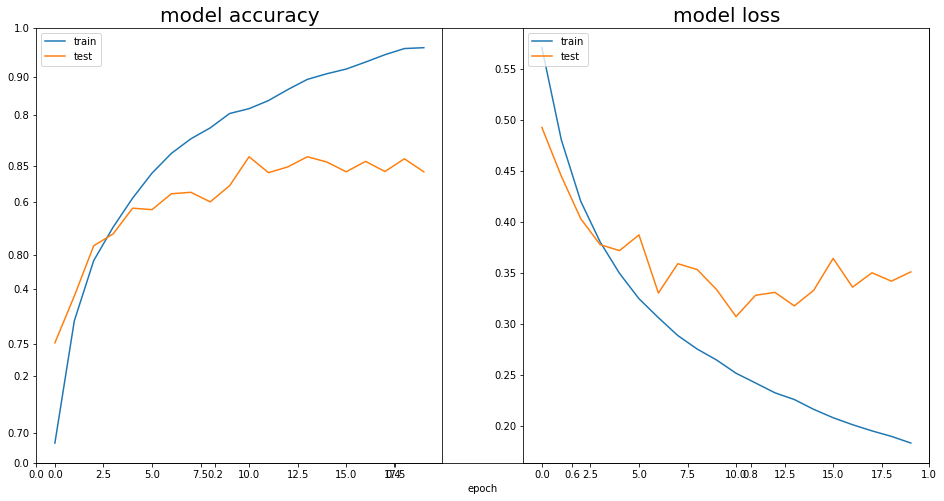

In [38]:
plt.clf()
f = plt.figure(figsize=(16, 8))
#plt.ylabel('accuracy')
plt.xlabel('epoch')

# summarize history for accuracy
ax1 = f.add_subplot(1, 2, 1)
ax1.plot(history_object.history['acc'])
ax1.plot(history_object.history['val_acc'])
ax1.set_title('model accuracy', fontsize=20)
ax1.legend(['train', 'test'], loc='upper left')

#summarize history for loss
ax2 = f.add_subplot(1, 2, 2)
ax2.plot(history_object.history['loss'])
ax2.plot(history_object.history['val_loss'])
ax2.set_title('model loss', fontsize=20)
ax2.legend(['train', 'test'], loc='upper left')

plt.show()
plt.savefig('model_loss.png')


In [ ]:
from keras.models import load_model
final_model = load_model('best_model.h5')